<a href="https://colab.research.google.com/github/1900690/strawberry/blob/main/Segmentation_superpixcel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#scikit-imageスーパーピクセル(SLIC,Compact watershed)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import  slic, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

import numpy as np
import matplotlib.pyplot as plt
from skimage import io,img_as_float, img_as_uint, img_as_ubyte

fname = '/content/image_67229953.jpg'


#img = img_as_float(astronaut()[::2, ::2])
img= img_as_float(io.imread(fname))

#call SLIC, with segment compactness = 10
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
gradient = sobel(rgb2gray(img))
#call watershed with segment compactness = 0.1
segments_watershed = watershed(gradient, markers=250, compactness=0.01)

#count the number of segments
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('watershed number of segments: {}'.format(len(np.unique(segments_watershed))))

fig, ax = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)

ax[0].imshow(mark_boundaries(img, segments_slic))
ax[0].set_title('SLIC')

ax[1].imshow(mark_boundaries(img, segments_watershed))
ax[1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

#openCVスーパーピクセル(スーパーピクセルSEEDS)

In [ ]:
import cv2
import math
import numpy as np
from google.colab.patches import cv2_imshow

def main():
    input_image = cv2.imread('/content/image_67229953.jpg')
    if input_image is None:
        print("ファイルオープンエラー")
        return -1

    # スーパーピクセルセグメンテーションの生成
    height, width, channels= input_image.shape[:3]
    num_iterations = 4
    prior = 2
    double_step = False
    num_superpixels = 500
    num_levels = 4
    num_histogram_bins = 5
    seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels, num_superpixels,
            num_levels, prior, num_histogram_bins, double_step)

    # 画像のスーパーピクセルセグメンテーションを計算
    # 入力画像は,HSVまたはL*a*b*
    converted = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)
    seeds.iterate(converted, num_iterations)

    # スーパーピクセルセグメンテーションの境界を取得
    contour_mask = seeds.getLabelContourMask(False)
    result = input_image.copy()
    result[0 < contour_mask] = ( 0, 255, 255)

    # セグメンテーション数の取得
    nseg = seeds.getNumberOfSuperpixels()

    # セグメンテーション分割情報の取得
    labels = seeds.getLabels()

    # セグメンテーション状況(ラベル情報)をランダムBGRでタイリング
    randcolor = np.random.randint(255, size=[nseg,3])
    lbsegimg = np.zeros((height, width, channels), dtype=np.uint8)
    for m in range(0, nseg):
        lbsegimg[labels == m] = randcolor[m]

    # セグメンテーション毎のBGR平均値を取得
    segavgimg = np.zeros((height, width, channels), dtype=np.uint8)
    lb = np.zeros((height, width), dtype=np.uint8)
    for m in range(0, nseg):
        lb.fill(0)
        lb[labels == m] = 255
        bgrm = cv2.mean(input_image, lb) # BGR平均値を取得

        # tuple float形式の平均値情報をint形式に変換
        bgr = [int(bgrm[0]), int(bgrm[1]), int(bgrm[2])]
        segavgimg[lb == 255] = bgr

    # 画像表示
    cv2_imshow(lbsegimg)
    cv2_imshow(result)
    #cv2_imshow(segavgimg)
    cv2.waitKey(0)
    return 0

if __name__ == '__main__':
    main()

#スーパーピクセルLSC

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def main():
    image = cv2.imread('/content/image_67229953_4cut.jpg')

    # BGR-HSV変換
    converted = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)

    # パラメータ
    region_size = 100 #スーパーピクセルの平均サイズ
    ruler = 0.1 #スーパーピクセル平滑係数
    min_element_size = 10 #
    num_iterations = 4 #

    # LSCインスタンス生成
    slc = cv2.ximgproc.createSuperpixelLSC(converted, region_size,float(ruler))
    slc.iterate(num_iterations)
    slc.enforceLabelConnectivity(min_element_size)

    # スーパーピクセルセグメンテーションの境界を取得
    contour_mask = slc.getLabelContourMask(False)
    image[0 < contour_mask] = (0, 255, 255)
    cv2_imshow(image)
    cv2.waitKey(0)

if __name__ == '__main__':
    main()


#スーパーピクセルSEEDS

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def main():
    image = cv2.imread('/content/image_67229953_4cut.jpg')

    # パラメータ
    height, width, channels= image.shape[:3]
    num_iterations = 5#
    prior = 2#平滑オプション(0～5) 3x3平滑化を有効にします。
    double_step = True#Trueの場合、精度向上の為、各ブロックレベルをダブルで実施
    num_superpixels = 700#必要なスーパーピクセルセグメンテーション数
    num_levels = 4#ブロックレベルの数
    num_histogram_bins = 5#ヒストグラムビンの数

    # スーパーピクセルSEEDSの生成
    seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels, num_superpixels,
            num_levels, prior, num_histogram_bins, double_step)

    converted = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)

    # 画像のスーパーピクセルSEEDSを計算
    seeds.iterate(converted, num_iterations)

    # スーパーピクセルセグメンテーションの境界を取得
    contour_mask = seeds.getLabelContourMask(False)
    result = image.copy()
    result[0 < contour_mask] = (0, 255, 255)

    # 画像表示
    cv2_imshow(result)
    cv2.waitKey(0)

if __name__ == '__main__':
    main()


#スーパーピクセルSLIC

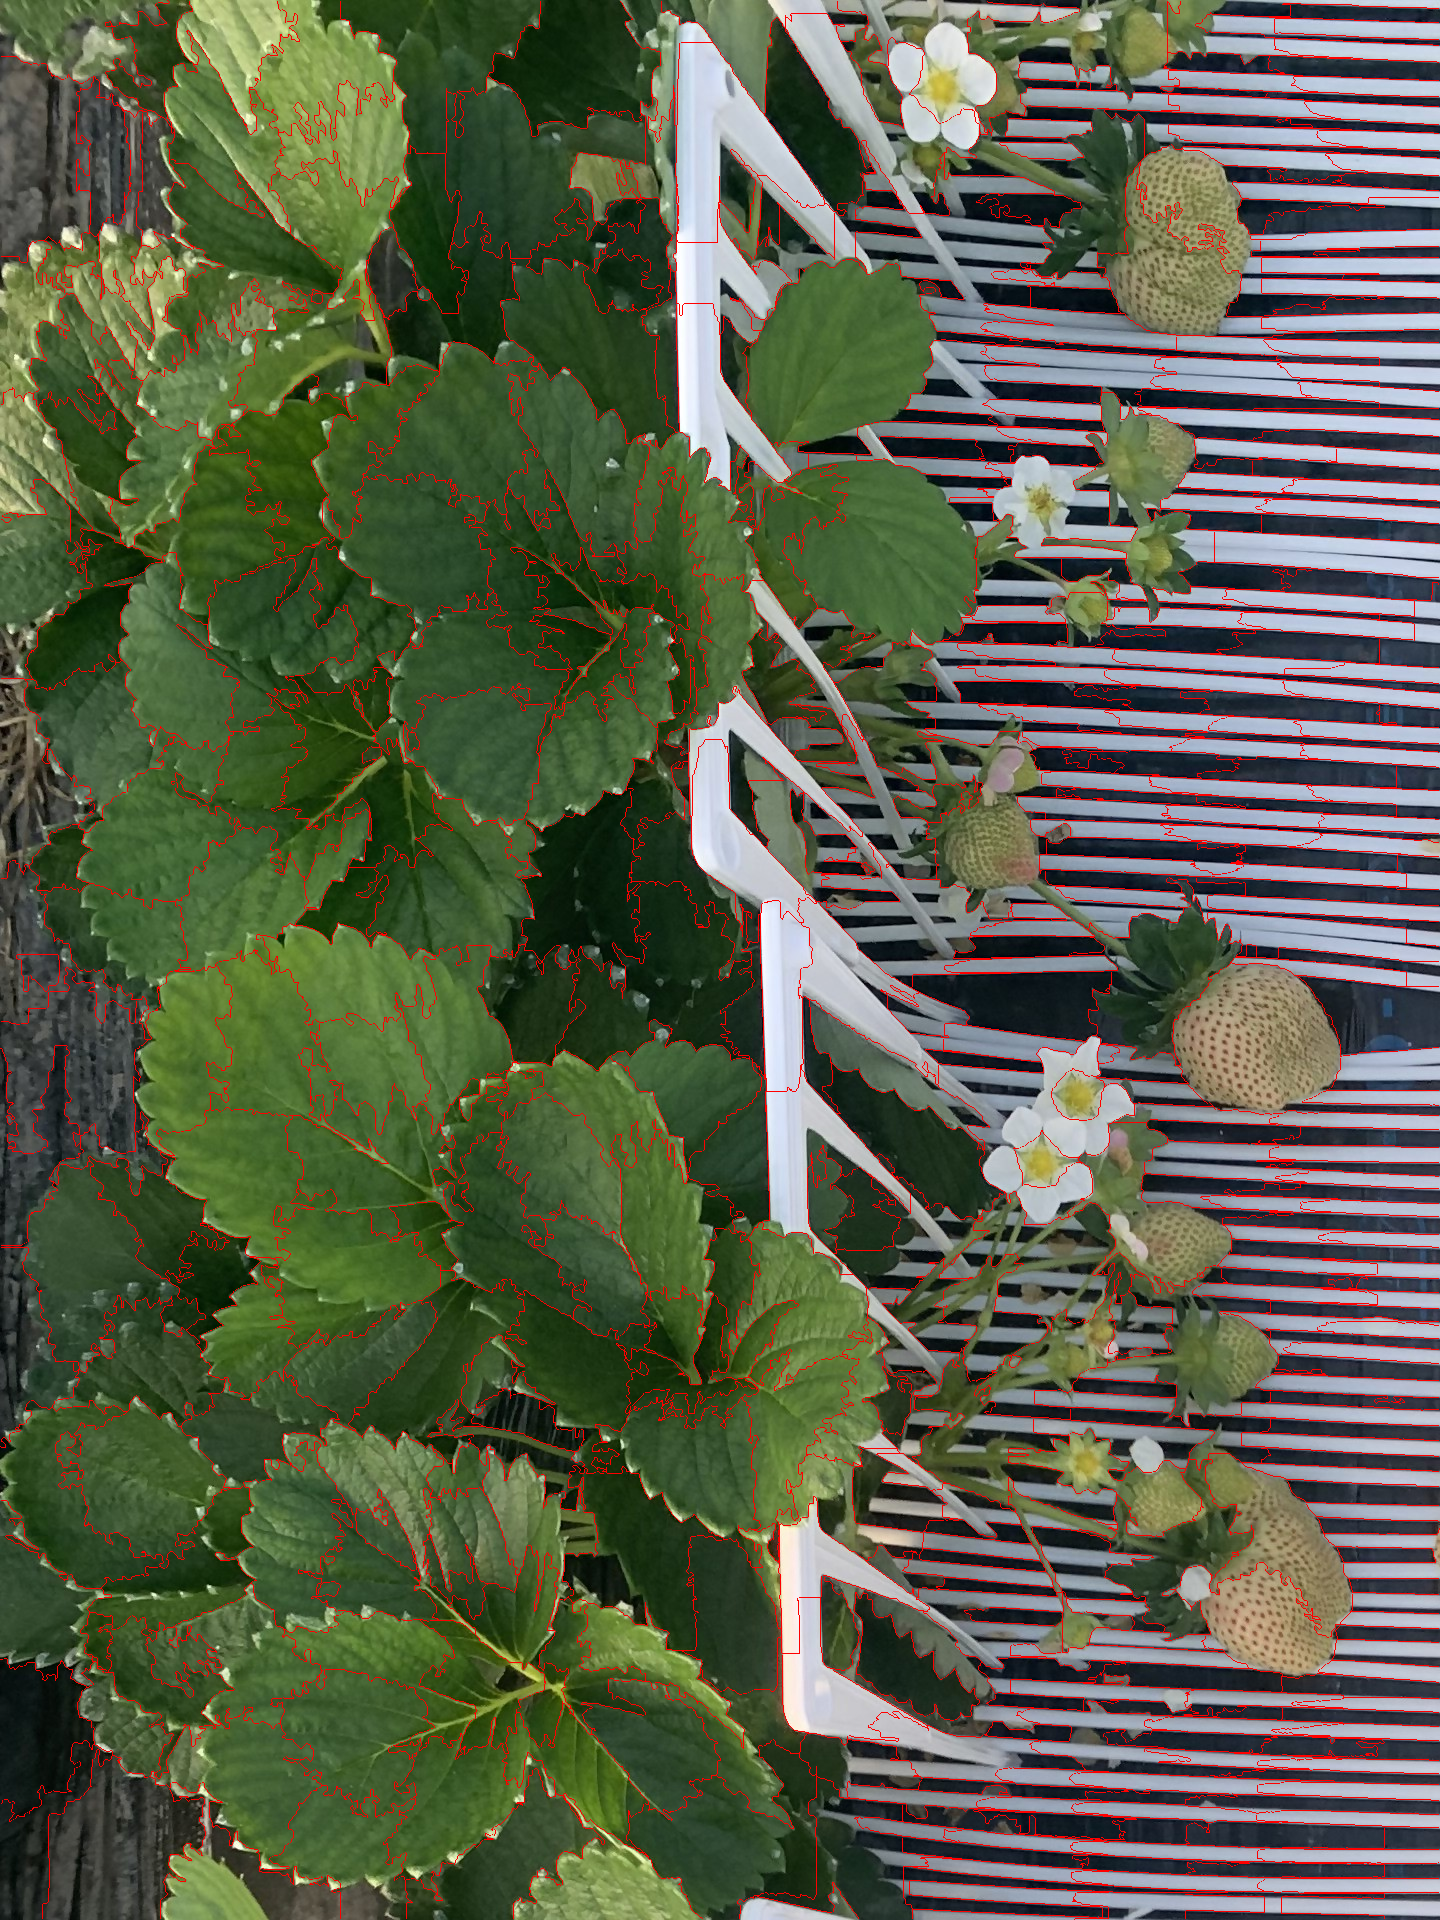

In [22]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

#def main():
image = cv2.imread('/content/image_67229953_4cut.jpg')

# パラメータ
algorithms = [
    ('SLIC', cv2.ximgproc.SLIC)]
    #('SLICO', cv2.ximgproc.SLICO),
    #('MSLIC', cv2.ximgproc.MSLIC) ]
region_size = 100
ruler = 30
min_element_size = 10
num_iterations = 4

# BGR-HSV変換
converted = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)
for alg in algorithms:
    slic = cv2.ximgproc.createSuperpixelSLIC(converted, alg[1], region_size,float(ruler))
    slic.iterate(num_iterations)
    slic.enforceLabelConnectivity(min_element_size)
    result = image.copy()

    # スーパーピクセルセグメンテーションの境界を取得
    contour_mask = slic.getLabelContourMask(False)
    result[0 < contour_mask] = (0, 0, 255)
    #cv2_imshow(contour_mask)
    cv2_imshow(result)
    #cv2.imwrite('/content/SLIC_'+alg[0]+'_result.jpg', result)
    cv2.imwrite('/content/SLIC_'+alg[0]+'_mask.png', contour_mask)
    cv2.waitKey(0)

#if __name__ == '__main__':
#    main()
